In [1]:
cd ..

/home/janek/reasonable-embeddings


In [2]:
import numpy as np
import pandas as pd
import torch as T
import torch.nn.functional as F
import torch.nn as nn
from sklearn import metrics

from src.reasoner_mod import *
from src.generate import load_dataset
from src.reasoner import *
from src.utils import *
from src.vis import *
import random

In [3]:
seed = 2022
dataset_path = 'local/out/dataset/sub-100.json'
ts = timestr()
train_onto, test_onto, data_tr, data_vl, data_te = load_dataset(dataset_path)

emb_size = 10
hidden_size = 16
epoch_count = 15
test_epoch_count = 10
batch_size = 32

T.manual_seed(seed)
random.seed(seed)
trained_reasoner = ModifiedReasonerHead(emb_size=emb_size, hidden_size=hidden_size)
encoders = [ModifiedEmbeddingLayer.from_onto(onto, emb_size=emb_size) for onto in train_onto]

print(f'created reasoner with {paramcount(trained_reasoner)} parameters')
print(f'created {len(encoders)} encoders with {paramcount(encoders[0])} parameters each')

# train_logger = train_mod(data_tr, data_vl, trained_reasoner, encoders, epoch_count=epoch_count, batch_size=batch_size, identities_weight=0.4, identitity_weight_decay=0.84)

created reasoner with 3283 parameters
created 40 encoders with 1270 parameters each


In [5]:
import pandas as pd
from sklearn.model_selection import train_test_split

data_test = pd.DataFrame({
    'ontology_id': data_te[0],
    'X': data_te[1],
    'y': data_te[2]
})

def stratified_group_split(data, group_col, stratify_col, test_size=0.2, val_size=0.2):
    groups = data[group_col].unique()
    train_idx, val_idx, test_idx = [], [], []

    for group in groups:
        group_data = data[data[group_col] == group]
        train_data, temp_data = train_test_split(group_data, test_size=(test_size + val_size), stratify=group_data[stratify_col])
        val_data, test_data = train_test_split(temp_data, test_size=test_size/(test_size + val_size), stratify=temp_data[stratify_col])

        train_idx.extend(train_data.index)
        val_idx.extend(val_data.index)
        test_idx.extend(test_data.index)

    return data.loc[train_idx], data.loc[val_idx], data.loc[test_idx]

train_data, val_data, test_data = stratified_group_split(data_test, 'ontology_id', 'y', test_size=0.2, val_size=0.2)

X_train = train_data['X'].tolist()
y_train = train_data['y'].tolist()
ontology_id_train = train_data['ontology_id'].tolist()

data_te_tr = [ontology_id_train,X_train, y_train] 

X_val = val_data['X'].tolist()
y_val = val_data['y'].tolist()
ontology_id_val = val_data['ontology_id'].tolist()

data_te_vl = [ontology_id_val, X_val, y_val] 

X_te = X_test = test_data['X'].tolist()
y_te = y_test = test_data['y'].tolist()
idx_te = ontology_id_test = test_data['ontology_id'].tolist()


In [10]:
## --- TESTING
trained_test_encoders = {}
T.manual_seed(seed)
random_reasoner = ReasonerHead(emb_size=emb_size, hidden_size=hidden_size)
test_logger = TrainingLogger(validate=True, metrics=batch_stats)

for reasoner_name, reasoner in [('trained reasoner', trained_reasoner), ('random reasoner', random_reasoner)]:
    print(reasoner_name)
    T.manual_seed(seed)
    trained_test_encoders[reasoner_name] = test_encoders = [EmbeddingLayer.from_onto(onto, emb_size=emb_size) for onto in test_onto]
    if reasoner_name == 'trained reasoner':
        train_mod(data_te_tr, data_te_vl, reasoner, test_encoders, epoch_count=test_epoch_count, batch_size=batch_size, run_name=reasoner_name, freeze_reasoner=True, logger=test_logger, identities_weight=0.35, identitity_weight_decay=0.86)
    #else:
        #train(data_te, None, reasoner, test_encoders, epoch_count=test_epoch_count, batch_size=batch_size, run_name=reasoner_name, freeze_reasoner=True, logger=test_logger)

trained reasoner
train epoch 00/10 | batch 751/750 | loss 1.5817 | val loss 1.2578 | acc 0.6575 | f1 0.4028 | prec 0.3241 | recall 0.5320 | roc auc 0.6475 | pr auc 0.4399 | elapsed 10.20s
train epoch 01/10 | batch 751/750 | loss 1.4179 | val loss 1.0250 | acc 0.6963 | f1 0.4365 | prec 0.3654 | recall 0.5417 | roc auc 0.6871 | pr auc 0.4923 | elapsed 22.27s
train epoch 02/10 | batch 751/750 | loss 1.1151 | val loss 0.8396 | acc 0.7295 | f1 0.4717 | prec 0.4095 | recall 0.5561 | roc auc 0.7268 | pr auc 0.5431 | elapsed 22.95s
train epoch 03/10 | batch 751/750 | loss 0.8896 | val loss 0.6986 | acc 0.7605 | f1 0.5100 | prec 0.4588 | recall 0.5740 | roc auc 0.7651 | pr auc 0.5945 | elapsed 23.02s
train epoch 04/10 | batch 751/750 | loss 0.7075 | val loss 0.5924 | acc 0.7900 | f1 0.5574 | prec 0.5138 | recall 0.6091 | roc auc 0.7996 | pr auc 0.6439 | elapsed 23.57s
train epoch 05/10 | batch 751/750 | loss 0.5642 | val loss 0.5144 | acc 0.8109 | f1 0.5930 | prec 0.5566 | recall 0.6344 | roc a

In [11]:
with T.no_grad():
    # idx_te, X_te, y_te = data_te
    _, _, Y_te_good = eval_batch_mod(trained_reasoner, trained_test_encoders['trained reasoner'], X_te, y_te, idx_te)
    #_, _, Y_te_rand = eval_batch(random_reasoner, trained_test_encoders['random reasoner'], X_te, y_te, idx_te)

local/out/exp/20240710T114059


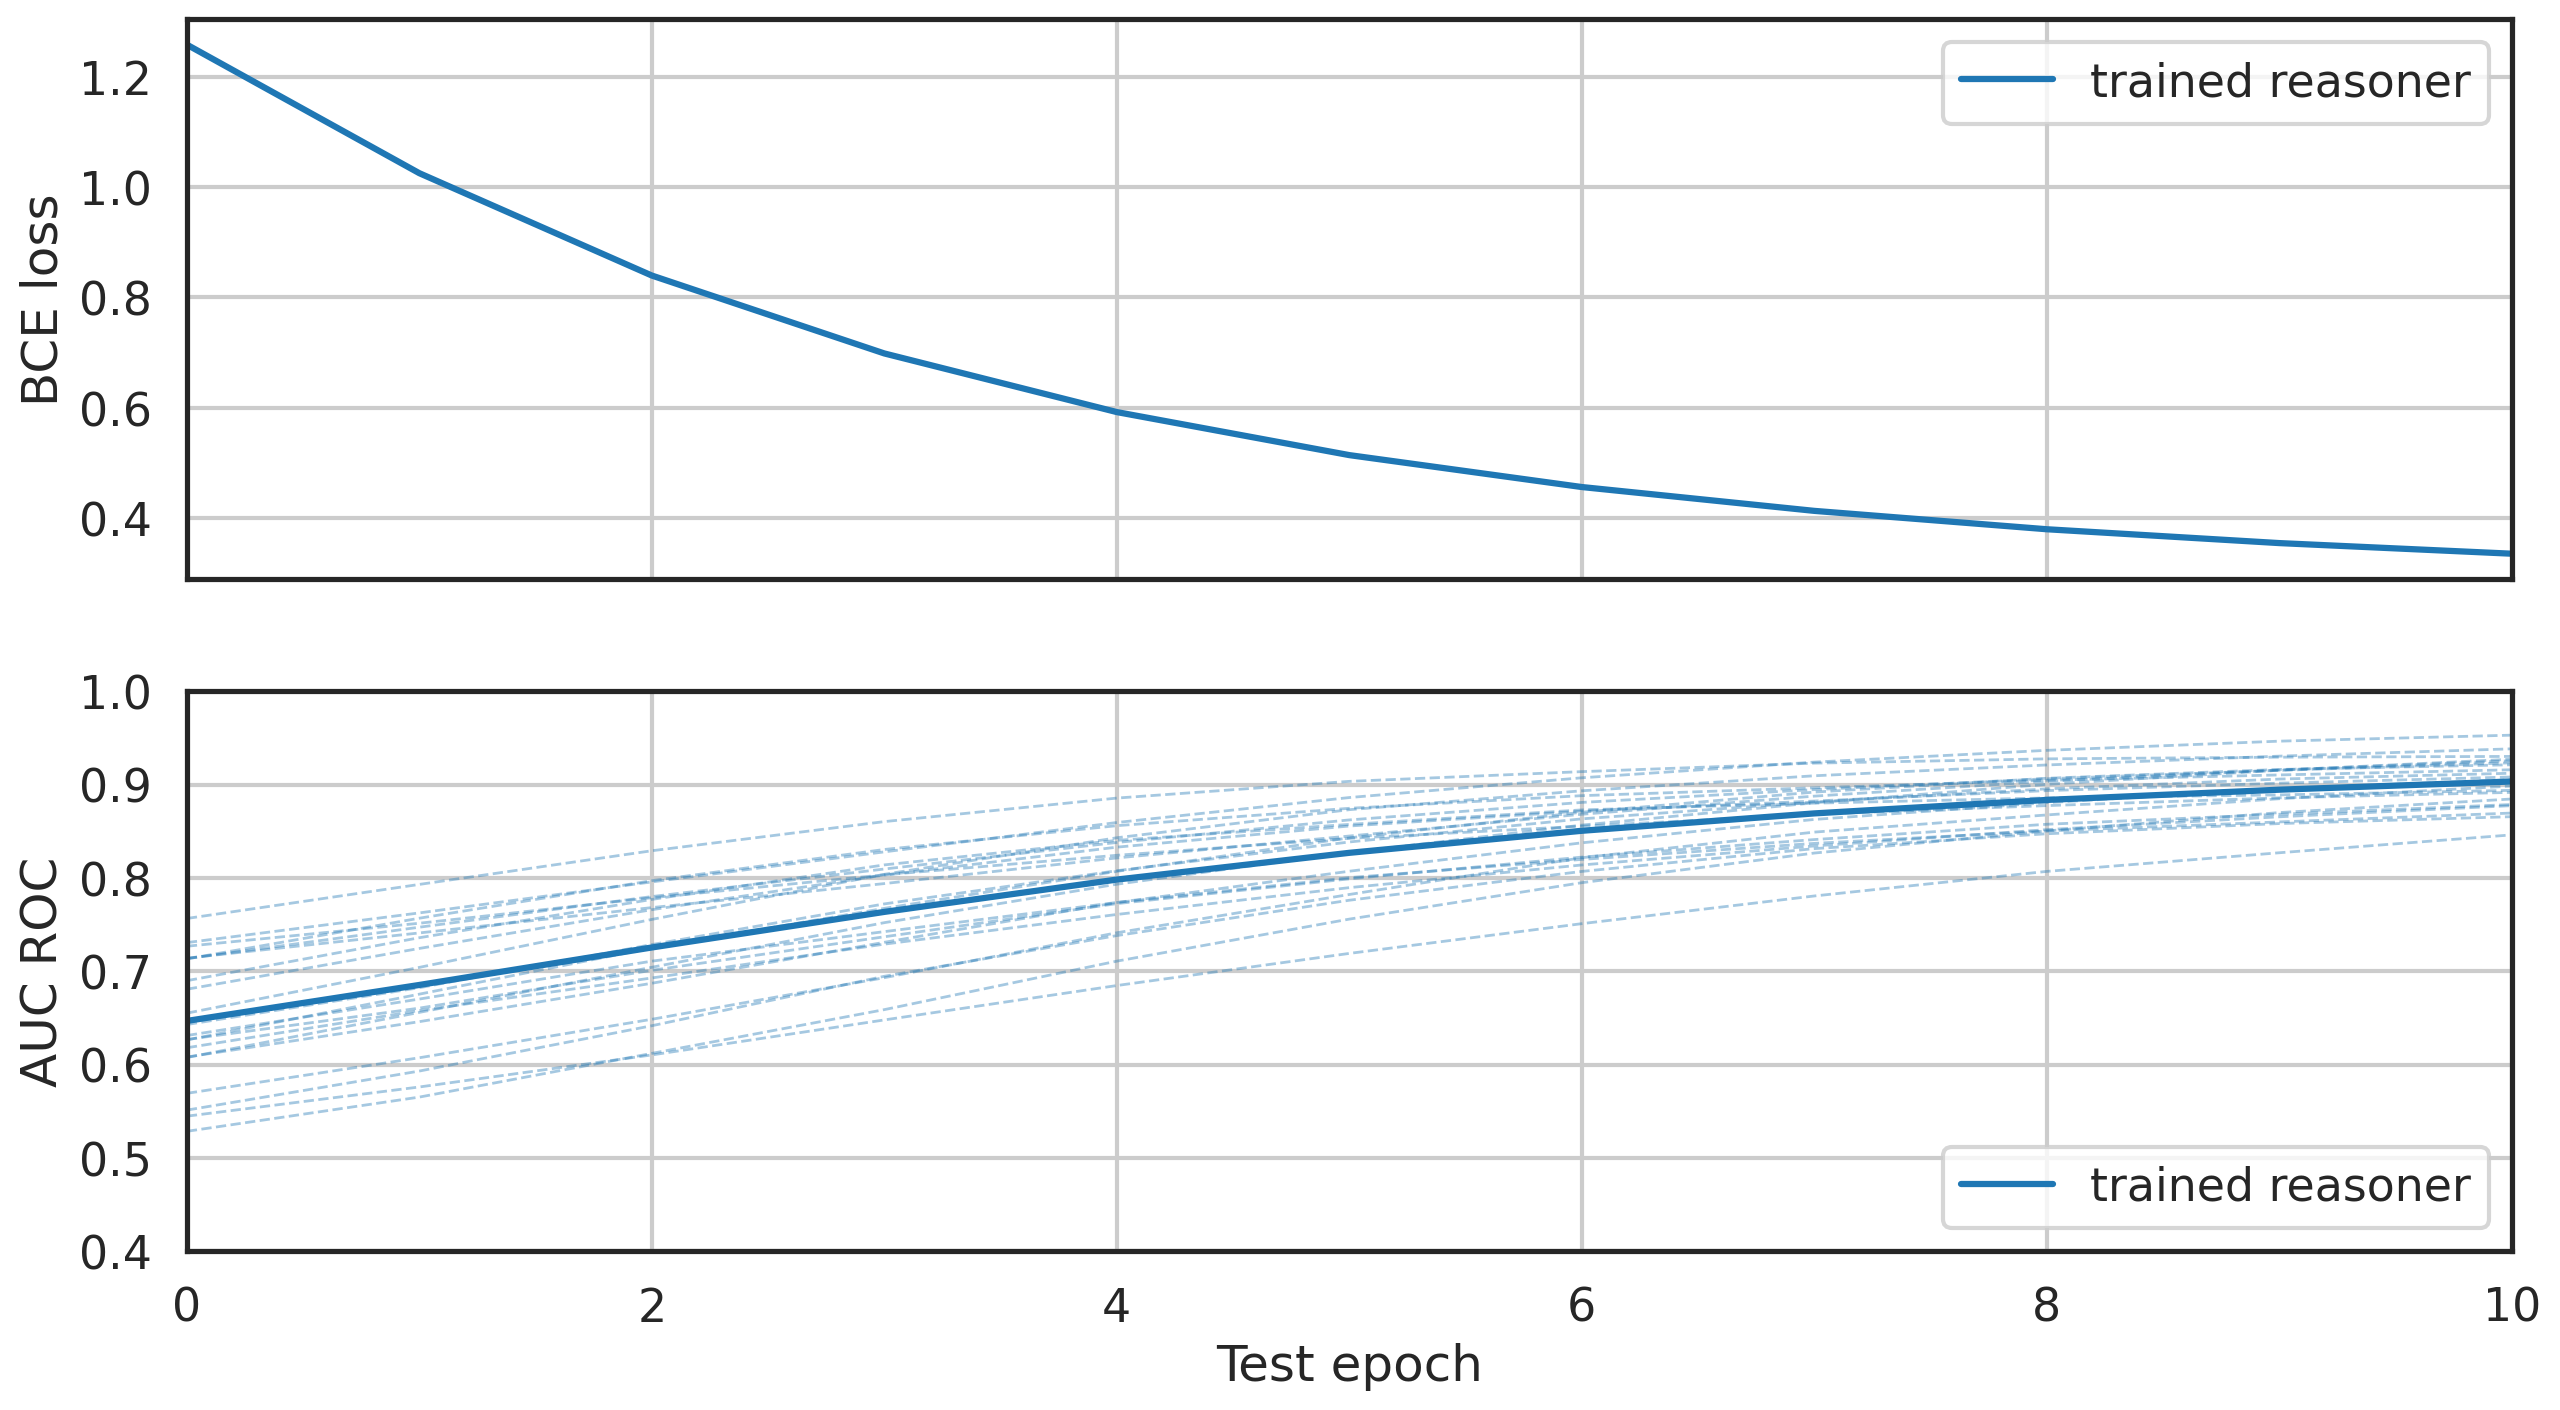

             mean       std     micro
acc      0.884875  0.033585  0.884875
prec     0.720309  0.081737  0.718933
recall   0.771900  0.066450  0.773823
f1       0.744376  0.071340  0.745369
auc_roc  0.912589  0.034521  0.914261
auc_pr   0.838228  0.064175  0.841693


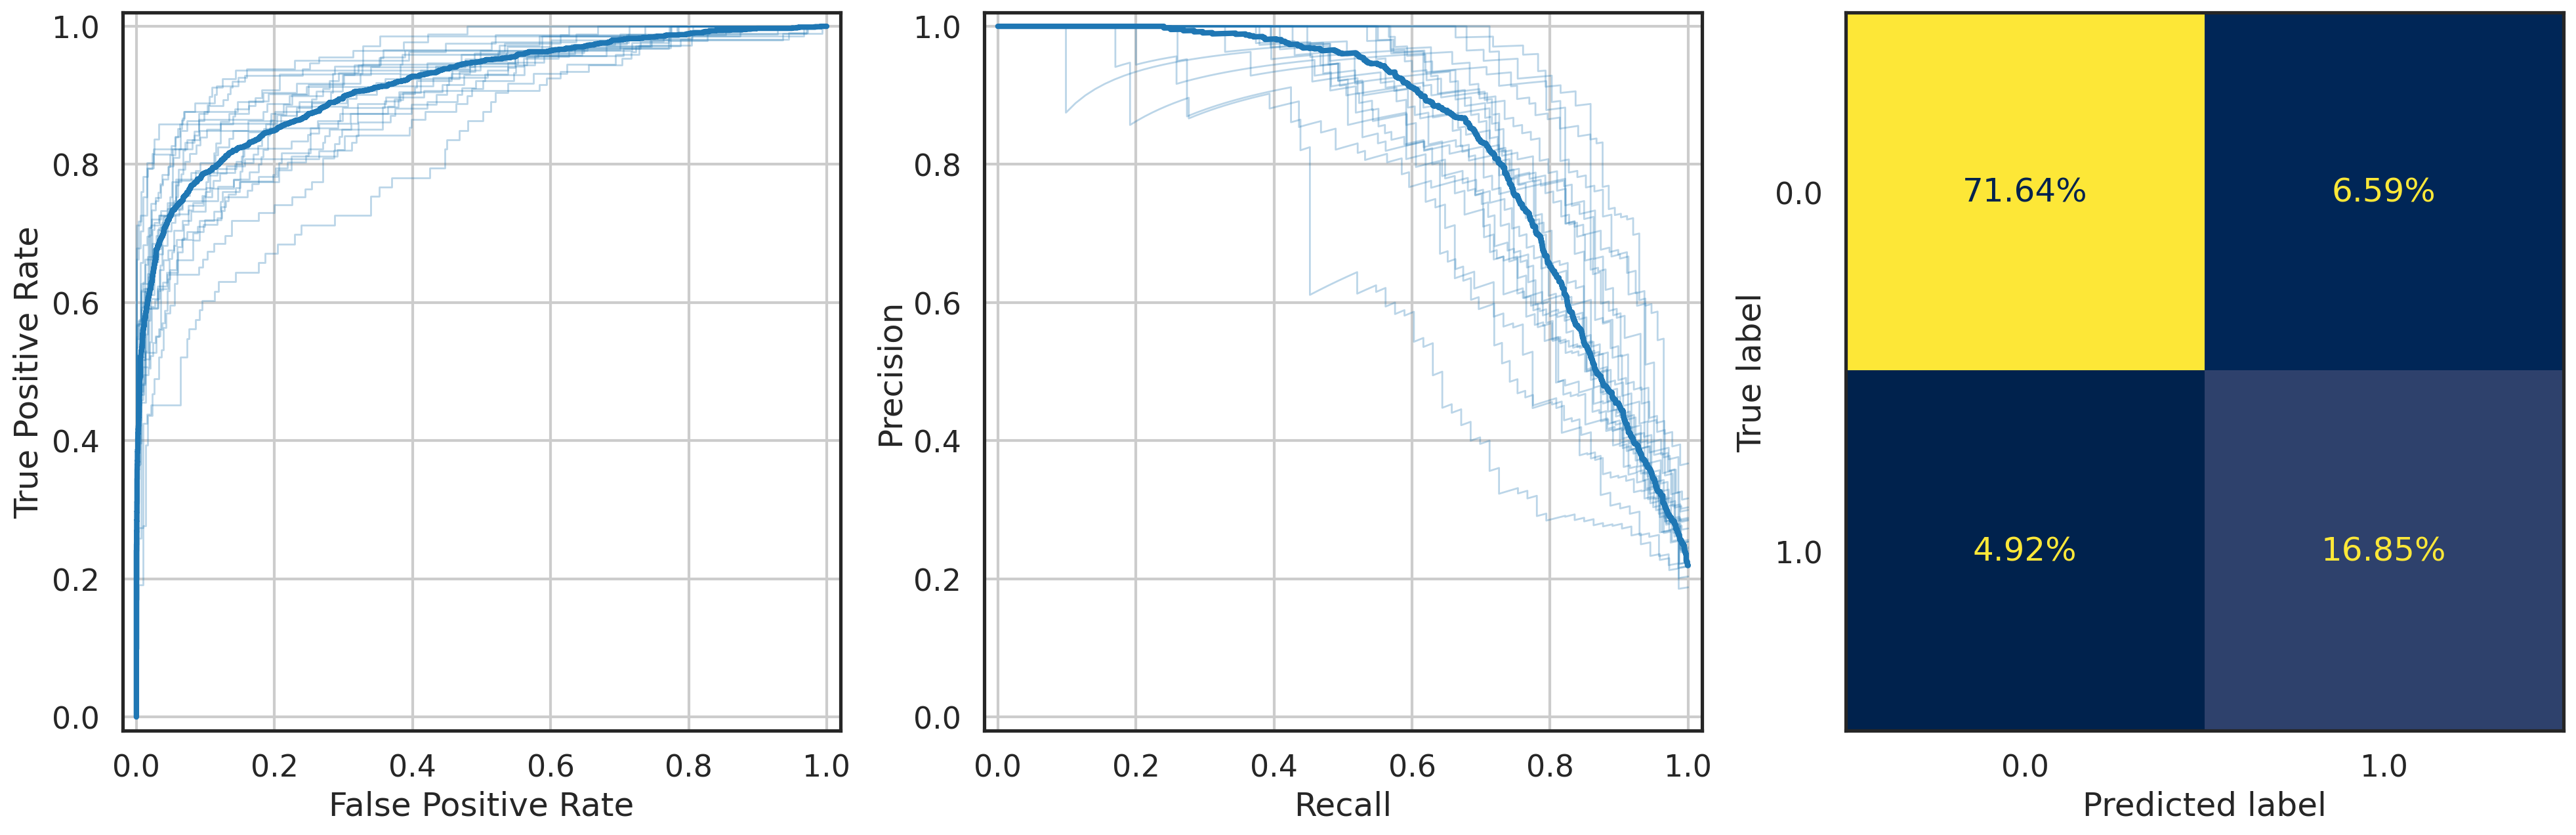

In [12]:
base = 'local/out/exp/' + ts
mkdirp(base)
print(base)

T.save(trained_reasoner.state_dict(), base+'/reasoner.pt')
# df_tr = pd.DataFrame(train_logger.history_tr)
# df_vl = pd.DataFrame(train_logger.history_vl)
# df_tr.to_csv(base+'/train.csv', index=False)
# df_vl.to_csv(base+'/valid.csv', index=False)
# plot_train_history(df_tr, df_vl, save=base+'/train.png')

test_history_by_onto = pd.DataFrame(test_logger.history_vl_by_onto)
test_history = pd.DataFrame(test_logger.history_vl)
test_results = pd.DataFrame(dict(idx_te=idx_te, y_te=y_te, Y_te_good=Y_te_good))#, Y_te_rand=Y_te_rand))
test_history.to_csv(base+'/test.csv', index=False)
test_history_by_onto.to_csv(base+'/test-grouped.csv', index=False)
test_results.to_csv(base+'/test-results.csv', index=False)
plot_test_history(test_history, test_history_by_onto, save=base+'/test.png')
print(report(test_onto, y_te, np.array(Y_te_good), idx_te, save=base+'/%-trained'))
#print(report(test_onto, y_te, np.array(Y_te_rand), idx_te, save=base+'/%-random'))

In [ ]:
T.set_printoptions(precision=3)

In [ ]:
losses = []
for _ in range(20):
    encoder = encoders[int(np.round(random.random() * (len(encoders ) - 1) , 0))]
    input = encoder.concepts[ int(np.round( random.random() * encoder.n_concepts , 0) - 1) ]
    losses.append( F.l1_loss(input, trained_reasoner.and_nn(im_mod(input, input))).item() )


print(input)
print(trained_reasoner.and_nn(im_mod( input, input)))
print(np.mean(losses))

tensor([-0.092, -0.011,  0.084,  0.144, -0.102,  0.230, -0.114,  0.085, -0.087,
         0.015], grad_fn=<SelectBackward0>)
tensor([ 0.025, -0.009,  0.019,  0.018,  0.009,  0.102, -0.112, -0.037, -0.010,
         0.003], grad_fn=<AddBackward0>)
0.08636397495865822


In [ ]:
losses = []
for _ in range(20):
    encoder = encoders[int(np.round(random.random() * (len(encoders ) - 1) , 0))]
    input = encoder.concepts[ int(np.round( random.random() * encoder.n_concepts , 0) - 1) ]
    losses.append(F.l1_loss(trained_reasoner.and_nn(im_mod(trained_reasoner.bot_concept[0], input)), trained_reasoner.bot_concept[0]).item())
print(trained_reasoner.bot_concept[0])
print(trained_reasoner.and_nn(im_mod(trained_reasoner.bot_concept[0], input)))
print(np.mean(losses))

tensor([ 0.259,  0.157,  0.147, -0.233,  0.262, -0.112, -0.002, -0.045, -0.060,
        -0.102], grad_fn=<SelectBackward0>)
tensor([ 0.243,  0.154,  0.100, -0.204,  0.221, -0.069,  0.010, -0.074, -0.051,
        -0.083], grad_fn=<AddBackward0>)
0.016945520183071494


In [ ]:
losses = []
for _ in range(20):
    encoder = encoders[int(np.round(random.random() * (len(encoders ) - 1) , 0))]
    input = encoder.concepts[ int(np.round( random.random() * encoder.n_concepts , 0) - 1) ]
    losses.append(F.l1_loss(trained_reasoner.and_nn(im_mod(trained_reasoner.top_concept[0], input)), input).item())

print(input)
print(trained_reasoner.and_nn(im_mod(trained_reasoner.top_concept[0], input)))
print(np.mean(losses))

tensor([-0.164,  0.005, -0.254, -0.004,  0.057, -0.117, -0.228, -0.125,  0.136,
        -0.153], grad_fn=<SelectBackward0>)
tensor([-0.083, -0.069, -0.109,  0.014, -0.021, -0.043, -0.123, -0.106,  0.074,
         0.019], grad_fn=<AddBackward0>)
0.07848630398511887


In [ ]:
losses = []
for _ in range(20):

    encoder = encoders[int(np.round(random.random() * (len(encoders ) - 1) , 0))]
    input = encoder.concepts[ int(np.round( random.random() * encoder.n_concepts , 0) - 1) ]
    output = trained_reasoner.and_nn(im_mod(trained_reasoner.not_nn(input), input))
    losses.append(F.l1_loss(trained_reasoner.bot_concept[0], output).item())

print(trained_reasoner.bot_concept[0])
print(output)
print(np.mean(losses))

tensor([ 0.2587,  0.1570,  0.1469, -0.2327,  0.2619, -0.1117, -0.0018, -0.0452,
        -0.0605, -0.1022], grad_fn=<SelectBackward0>)
tensor([ 0.0839, -0.0574, -0.0736, -0.1156,  0.1467, -0.0434, -0.1084, -0.2190,
         0.1195,  0.1066], grad_fn=<AddBackward0>)
0.09178195530548691


In [ ]:
print(trained_reasoner.bot_concept[0])
output = trained_reasoner.not_nn(trained_reasoner.top_concept[0])
print(output)
print(F.l1_loss(trained_reasoner.bot_concept[0], output))

tensor([ 0.2587,  0.1570,  0.1469, -0.2327,  0.2619, -0.1117, -0.0018, -0.0452,
        -0.0605, -0.1022], grad_fn=<SelectBackward0>)
tensor([ 0.3023,  0.2244,  0.2153, -0.3046,  0.3299, -0.1540,  0.0038, -0.0118,
        -0.0991, -0.1751], grad_fn=<SqueezeBackward3>)
tensor(0.0512, grad_fn=<L1LossBackward0>)


In [ ]:
print(trained_reasoner.top_concept[0])
output = trained_reasoner.not_nn(trained_reasoner.bot_concept[0])
print(output)
print(F.l1_loss(trained_reasoner.top_concept[0], output))

tensor([-0.1591, -0.2129, -0.1131,  0.4662,  0.1262,  0.2902,  0.5642,  0.1730,
        -0.1271,  0.3226], grad_fn=<SelectBackward0>)


tensor([-0.1006, -0.1636, -0.0800,  0.3705,  0.0448,  0.2314,  0.4407,  0.1590,
        -0.0444,  0.2821], grad_fn=<SqueezeBackward3>)
tensor(0.0638, grad_fn=<L1LossBackward0>)


In [ ]:
losses = []
for _ in range(20):
    encoder = encoders[int(np.round(random. random() * (len(encoders) - 1), 0))]
    input1 = encoder.concepts[int(np.round(random. random() * encoder.n_concepts, 0) - 1)]

    encoder = encoders[int(np.round(random. random() * (len(encoders) - 1), 0))]
    input2 = encoder.concepts[int(np.round(random. random() * encoder.n_concepts, 0) - 1)]

    encoder = encoders[int(np.round(random. random() * (len(encoders) - 1), 0))]
    input3 = encoder.concepts[int(np.round(random. random() * encoder.n_concepts, 0) - 1)]

    losses.append(F.l1_loss(trained_reasoner.and_nn(im_mod(input1, trained_reasoner.and_nn(im_mod(input2, input3)))), trained_reasoner.and_nn(im_mod(trained_reasoner.and_nn(im_mod(input1, input2)), input3))).item())

print(trained_reasoner.and_nn(im_mod(input1, trained_reasoner.and_nn(im_mod(input2, input3)))))
print(trained_reasoner.and_nn(im_mod(trained_reasoner.and_nn(im_mod(input1, input2)), input3)))
print(np.mean(losses))

tensor([ 0.1164,  0.0195,  0.0330, -0.0968,  0.0851,  0.0172, -0.0441, -0.1065,
         0.0681,  0.0030], grad_fn=<AddBackward0>)


tensor([ 0.0910,  0.0241,  0.0483, -0.0977,  0.0918, -0.0005, -0.0243, -0.1423,
         0.0539, -0.0035], grad_fn=<AddBackward0>)
0.017587524140253663


In [ ]:
losses = []
for _ in range(20):
    encoder = encoders[int(np.round(random. random() * (len(encoders) - 1), 0))]
    input1 = encoder.concepts[int(np.round(random. random() * encoder.n_concepts, 0) - 1)]

    encoder = encoders[int(np.round(random. random() * (len(encoders) - 1), 0))]
    input2 = encoder.concepts[int(np.round(random. random() * encoder.n_concepts, 0) - 1)]

    losses.append( F.l1_loss(trained_reasoner.and_nn(im_mod(input1, input2)), trained_reasoner.and_nn(im_mod(input2, input1))).item())

print(trained_reasoner.and_nn(im_mod(input1, input2)))
print(trained_reasoner.and_nn(im_mod(input2, input1)))

print(np.mean(losses))

tensor([ 0.0672,  0.0605, -0.0203, -0.0603,  0.0754, -0.0147, -0.0568, -0.1259,
         0.0360,  0.0237], grad_fn=<AddBackward0>)
tensor([ 0.1016,  0.0942, -0.0213, -0.0441,  0.0486,  0.0126, -0.0414, -0.0994,
         0.0294,  0.0010], grad_fn=<AddBackward0>)
0.015440697502344846


In [ ]:
losses = []
for _ in range(20):
    encoder = encoders[int(np.round(random. random() * (len(encoders) - 1), 0))]
    input1 = encoder.concepts[int(np.round(random. random() * encoder.n_concepts, 0) - 1)]
    losses.append(F.l1_loss(input1, trained_reasoner.and_nn(im_mod(input1, trained_reasoner.top_concept[0]))).item())

print(input1)
print(trained_reasoner.and_nn(im_mod(input1, trained_reasoner.top_concept[0])))

print(np.mean(losses))

tensor([-0.1756, -0.1937,  0.0193,  0.0207, -0.2022,  0.0467,  0.0119, -0.3805,
        -0.0392, -0.2627], grad_fn=<SelectBackward0>)
tensor([-0.1490, -0.1636, -0.0520,  0.0780, -0.1424,  0.0811, -0.0090, -0.2315,
         0.0204, -0.0226], grad_fn=<AddBackward0>)
0.06461446182802319


In [ ]:
losses = []
for _ in range(20):
    encoder = encoders[int(np.round(random. random() * (len(encoders) - 1), 0))]
    input1 = encoder.concepts[int(np.round(random. random() * encoder.n_concepts, 0) - 1)]
    losses.append( T.sigmoid(trained_reasoner.sub_nn(im_mod(input1, trained_reasoner.top_concept[0]))).item())
print(np.mean(losses))

0.9983007192611695


In [ ]:
losses = []
for _ in range(20):
    encoder = encoders[int(np.round(random. random() * (len(encoders) - 1), 0))]
    input1 = encoder.concepts[int(np.round(random. random() * encoder.n_concepts, 0) - 1)]
    losses.append(T.sigmoid(trained_reasoner.sub_nn(im_mod(trained_reasoner.bot_concept[0], trained_reasoner.bot_concept[0]))).item())
print(np.mean(losses))

0.999927282333374


In [ ]:
losses = []
for _ in range(20):
    encoder = encoders[int(np.round(random. random() * (len(encoders) - 1), 0))]
    input1 = encoder.concepts[int(np.round(random. random() * encoder.n_concepts, 0) - 1)]
    losses.append(T.sigmoid(trained_reasoner.sub_nn(im_mod(trained_reasoner.bot_concept[0], trained_reasoner.bot_concept[0]))).item())
print(np.mean(losses))

0.999927282333374


In [ ]:
print(T.round( T.matmul( trained_reasoner.not_nn.weight,trained_reasoner.not_nn.weight) *100)/100)

NameError: name 'T' is not defined